# Optimization Methods Project Work: SMO and DCD-Linear for training SVM

This notebook will contain the code used to accomplish the Laboratory of Optimization Methods.

The goal of it is to compare the performance between two algorithms for training linear SVM: Sequential Minimal Optimization (SMO), ad Dual Coordinates Decent (DCD). In this Notebook these algorithms will be implemented, and compared with the `LinearSVC` of `scikit-learn` to assert the correctness. After that, there will be comparative tests on performance over different settings.

## How are they different? And why are we testing them? 
In the context of SVM training, one of the biggest advantage of using the dual formulation comes from the **Kernel Trick**, that allows to implicitly map data on higher dimensions. In cases where data already has a lot of features, using the Kernel Trick is less effective, or even counterproductive. This thing said, **Linear SVM** are preferred, giving the possibility a more efficient formulation.

So, be $X \in \mathbf{R}^{n\times p}$ the dataset of $n$ elements and $p$ features, and $Y \in \{-1, 1\}^n$ the corresponding classes.
### SMO
SMO is a common way to solve the dual formulation of SVM training loss, and can be used even with the Kernel Trick.
$$
\begin{gathered}
\min_\alpha\frac{1}{2}\alpha^TQ\alpha - e^T\alpha\\
\alpha^Ty = 0\\
0 \leq \alpha \leq C\\
\end{gathered}
$$
This problem has a variable for every element in the dataset, making convenient the use of decomposition methods. But, due to the constraint $\alpha^Ty = 0$, we need to change 2 variables at time. It takes some elaboration to find a couple that gives an admissible and descent direction. Concluding, the overall cost to a single iteration is $O(pn)$.

### DCD
If we limit the use of a linear kernel, we can formulate the primal problem without a bias. To regain the same expressivity, we will add a constant feature equal to 1 for every element.
$$
\min_w \frac{1}{2}||w||^2 +C\sum_i^n\max\{0, 1 -y^i(w^Tx^i)\}
$$
This formulation in the dual becomes the same, but without the equality constraint.
$$
\begin{gathered}
\min_\alpha\frac{1}{2}\alpha^TQ\alpha - e^T\alpha\\
0 \leq \alpha \leq C\\
\end{gathered}
$$
This simplifies the cost of a single step, that can be performed a variable at time. The overall cost per step is $O(p)$, but requiring more steps than SMO.

## Testing the environment

The following cell will simply verify if all the libraries necessary to run the code are correctly installed. This cell **must** be executed every time, because contains every import used during all the Notebook.

In [56]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
import random
import time
import os
import json
import pandas as pd
import gc
from typing import Callable
from numpy.linalg import norm
from sklearn.datasets import load_svmlight_file
from sklearn.datasets import dump_svmlight_file
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from typing import Callable

print("Everything is installed correctly!")

Everything is installed correctly!


## Some support function

In this cell are defined some of the function that helps during all the experiments. There is also a definition of the SVM class, that can be called as a function and operate in the same way the classifies of `scikit-learn` works.

In [ ]:
def load_dataset(name: str, dimension: int = None, features: list = None):
    bias = load_svmlight_file(name)
    bias = (bias[0].toarray(), bias[1])

    if(dimension is not None):
        permutation = np.random.permutation(bias[0].shape[0])

        indexs = permutation[0:dimension]
        bias = (bias[0][indexs], bias[1][indexs])

    if features is not None:
        bias = (bias[0][:, features], bias[1])
    
    new_column = np.atleast_2d(np.ones(bias[0].shape[0])).T
    unbias = (np.hstack([bias[0], new_column]), bias[1])

    return (bias, unbias)
    
def feature_extractor(feature_num: int, original_num: int):
    permutation = np.random.permutation(original_num)
    return np.sort(permutation[0:feature_num])
    
def calculate_accuracy(true_y, data, model):
    preds = model(data)
    return classification_report(true_y, preds, zero_division=0, output_dict=True)["accuracy"]
            
class SVM:
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def __call__(self, x):
        return np.sign(x @ self.w + self.b)

def dual_loss_svm(a, Q):
    return 0.5 * (a.T @ Q @ a) - np.sum(a)

def loss_svm_obj(svm, C, X, y):
    return loss_svm(svm.w, svm.b, C, X, y)
    
def loss_svm(w, b, C, X, y):
    psi = np.maximum(np.zeros_like(y), np.ones_like(y) - y * (X @ w + np.ones_like(y) * b))
    return 0.5 * (w.T @ w) + C * np.sum(psi)

## Implementing SMO utilities

As we know, the formulation of the dual problem for training a SVM is:
$$
\begin{gather*}
\min_{\alpha} \frac{1}{2}\alpha^TQ\alpha - e^T\alpha \\
\forall i\ 0 \leq \alpha_i \leq C\ \ \sum \limits_i^n \alpha_iy_i = 0
\end{gather*}
$$

As stated in the Project Goals, we will use the Most Violating Pair rule to select the variables to change. So, to implement this algorithm efficiently, we need those elements:
* A function that calculates the derivatives
* A function that adjust the derivative after changing $\alpha$ 
* A function that extract the most violating pair.

To sum up all this functionality, they will be implemented inside a class. The constructor will receive the set of Xs and Ys, and using that will derive $Q$. There will be an implementation that calculates the $Q$ columns when needed, that can be used when calculating all $Q$ isn't doable.

In [ ]:
class DualSVMProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5, sparse = False):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(self.a)
        self.epsilon = epsilon
        self.sparse = sparse

        if sparse:
            self.calculated = [False] * self.Y.shape[0]
            self.Q = {}
        else:
            mat = np.stack([Ys.T] * Xs.shape[1], axis = 1)
            
            Z = Xs * mat
            self.Q = Z @ Z.T
        
        self.d = - self.e

    def getA(self):
        return self.a
        
    def getDerivative(self):
        return self.d    

    def getMostViolatingPair(self):
        
        directions = self.d / self.Y
        min_idx = -1
        min_value = np.inf
        max_idx = -1
        max_value = -np.inf
        
        R = directions.copy()
        R[np.logical_and(self.a < self.epsilon, self.Y == -1)] = np.inf
        R[np.logical_and(self.a > (self.C - self.epsilon), self.Y == 1)] = np.inf

        S = directions.copy()
        S[np.logical_and(self.a < self.epsilon, self.Y == 1)] = -np.inf
        S[np.logical_and(self.a > (self.C - self.epsilon), self.Y == -1)] = -np.inf

        min_idx = np.argmin(R)
        max_idx = np.argmax(S)

        if R[min_idx] == np.inf or S[max_idx] == -np.inf:
            return None
                
        return (min_idx, max_idx)

    def updateA(self, idx1, a1, idx2, a2):

        if self.sparse:
            self.d = self.getQColumn(idx1) * (a1 - self.a[idx1]) + self.getQColumn(idx2) * (a2 - self.a[idx2]) + self.d
        else:
            self.d = self.Q[idx1] * (a1 - self.a[idx1]) + self.Q[idx2] * (a2 - self.a[idx2]) + self.d
        
        self.a[idx1] = a1
        self.a[idx2] = a2

    def getParameters(self):
        mat = np.stack([self.a.T * self.Y.T] * self.X.shape[1], axis = 1)
        w = np.sum(mat * self.X, axis = 0)
        b = 0
        for i in range(len(self.a)):
            if(self.a[i] < self.epsilon or self.a[i] > self.C - self.epsilon):
                continue
            b = 1 / self.Y[i] - w @ self.X[i]
            break        
        return (w, b)

    def getQColumn(self, i):
        if self.sparse:
            if not self.calculated[i]:
                self.Q[i] = self.Y[i] * (self.Y * (self.X @ self.X[i]))
                self.calculated[i] = True
        return self.Q[i]

#### Testing the Implementation

The following cell test some functionality used to solve SMO, and see if they are correct.

In [ ]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

# The safe way to calculate matrix Q
Q = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        Q[i][j] = Y[i] * Y[j] * X[i] @ X[j]

problem = DualSVMProblem(X, Y, C)

ok = True
    
if ((np.array([-1, -1]) != problem.getDerivative()).all()):
    ok = False
    print("The derivative function if wrong")

update = np.array([1, 2])
problem.updateA(0, update[0], 1, update[1])

if (norm(Q[0] - problem.getQColumn(0)) > 1e-3 or norm(Q[1] - problem.getQColumn(1)) > 1e-3):
    ok = False
    print("The matix calculation is wrong")
    
if ((Q @ update - np.ones(2) != problem.getDerivative()).all()):
    ok = False
    print("The updates of variables doesn't update the derivative in the right way")

elements = problem.getDerivative() / Y

if not (problem.getMostViolatingPair()[0] == (0 if elements[0] < elements[1] else 1) and problem.getMostViolatingPair()[1] == (0 if elements[0] > elements[1] else 1)):
    ok = False
    print("The calculation of the most violating pair is wrong")
    # This test is a bit odd and not exaustive, but can help

if ok:
    print("Everything is working as expected!")

## Implement SMO outer Loop

After implementing core elements for the SMO algorithm, it's time to get them together and build the actual result.
In this implementation, I realized a function that execute a single iteration of the algorithm, leaving the check of convergence outside. In this way, we can use different stopping conditions.

`SMO_step` uses the SMO functionality to do a single optimization step, `trainingSMO` and `trainingSMOtimed` use a single step until the termination condition is reached.

In [ ]:
def trainingSMO(problem: DualSVMProblem, step: Callable[[DualSVMProblem], bool], epsilon = 1e-5, verbose = False):
    loss = []
    validation = []
    
    while(True): 
        (min_idx, max_idx) = problem.getMostViolatingPair()
        elements = problem.getDerivative() / problem.Y

        if verbose:
            print(f"Stopping condition: {elements[max_idx] - elements[min_idx]}")
        if(elements[min_idx] + epsilon > elements[max_idx]):
            break
        
        result = step(problem)            
        (w, b) = problem.getParameters()
        svm = SVM(w, b)
        
        if not result:
            # If the step method give False as a result indicates an error or a stop condition (i.e. having a derivative under the tollerance)
            break

    return (loss, validation)
    
def trainingSMOtimed(Xs, Ys, C, step: Callable[[DualSVMProblem], bool], test_time: float, sparse = False):
    total_time = 0
    start_time = time.time()
    problem = DualSVMProblem(Xs, Ys, C, sparse = sparse)
    while(True): 
        (min_idx, max_idx) = problem.getMostViolatingPair()
        result = step(problem)
        if not result:
            return -1
        total_time = time.time() - start_time
        
        if (total_time > test_time):
            return (total_time, problem)

    return (loss, validation)

def SMO_step(problem: DualSVMProblem, epsilon: float = 1e-5):
    test = problem.getMostViolatingPair()
    if(test is None):
        raise Exception("The problem did not give a valid violating pair")
    (min_idx, max_idx) = (test[0], test[1])

    direction = np.zeros_like(problem.a)
    direction[min_idx] = 1 * problem.Y[min_idx]
    direction[max_idx] = - 1 * problem.Y[max_idx] #In theory I should divide, but y is in {-1, 1} making the multiplication equivalent, but more efficient

    derivative = problem.getDerivative()

    b = problem.C - problem.a[min_idx] if direction[min_idx] > 0 else problem.a[min_idx]
    b = min(b, problem.C - problem.a[max_idx] if direction[max_idx] > 0 else problem.a[max_idx])
    
    if b < epsilon:
        return False

    tmp = problem.getQColumn(min_idx) * problem.Y[min_idx] - problem.getQColumn(max_idx) * problem.Y[max_idx]   
    value = direction.T @ tmp

    if value > epsilon:
        b = min(b, -(derivative.T @ direction) / value)

    problem.updateA(min_idx, problem.a[min_idx] + b * direction[min_idx], max_idx, problem.a[max_idx] + b * direction[max_idx])
    return True    

## Converting the datasets

Give the way this notebook implements the operation, the classes are needed to be in $\{-1, 1\}$. So, in the following cell, the classes arrays are translated to meet this requirement.

In addition to that, there is a resume of the principal statistical index of all features.

In [ ]:
(Xs, Ys) = load_svmlight_file("datasets/covtype_scale")
Ys[Ys == 2] = -1

Xs = Xs.toarray()

dump_svmlight_file(Xs, Ys, "datasets/covtype_ones")
dataframe = pd.DataFrame(Xs)
dataframe.describe()

In [ ]:
(Xs, Ys) = load_svmlight_file("datasets/breast_cancer_scale")
Ys[Ys == 2] = 1
Ys[Ys == 4] = -1 

Xs = Xs.toarray()

dump_svmlight_file(Xs, Ys, "datasets/breast_cancer_ones")

# There is a lot to say (Xs originally is a sparce matrix, not scaled values broke the model, Ys classes are 2 and 4)
dataframe = pd.DataFrame(Xs)
dataframe.describe()

## Testing the Code

In the following cells, I will use a very simple classification problem to see if the code works at all. [This dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#breast-cancer) is composed by only 683 elements, everyone of only 10 features. This dataset is chosen dues to it contained dimension. In fact, this implementation of the Dual SVM explicitly calculate the Q matrix, something that can become prohibitive very quickly in the increase of elements.

In [ ]:
(train_Xs, test_Xs, train_Ys, test_Ys)  = train_test_split(Xs, Ys, test_size = 0.20)

base_svm = LinearSVC(C = 10)
base_svm.fit(train_Xs, train_Ys)

train_preds = base_svm.predict(train_Xs)
test_preds = base_svm.predict(test_Xs)


print("Report on train set:")
print(classification_report(train_Ys, train_preds, zero_division = 0))

print("Report on test set:")
print(classification_report(test_Ys, test_preds, zero_division = 0))

In [ ]:
base_smo_problem = DualSVMProblem(train_Xs, train_Ys, C = 10)

(_, _) = trainingSMO(base_smo_problem, SMO_step, epsilon = 1e-2)

(w, b) = base_smo_problem.getParameters()
smo_svm = SVM(w, b)
smo_train_preds = smo_svm(train_Xs)
smo_test_preds = smo_svm(test_Xs)

print("Result of the model trained using SMO on training set:")
print(classification_report(train_Ys, smo_train_preds, zero_division=0))

print("Result of the model trained using SMO on test set:")
print(classification_report(test_Ys, smo_test_preds, zero_division=0))

Those simple test are not so determinant, but can give some insight on how much the obtained model differ from the `LinearSVC` one.

In [ ]:
print(f"Difference in norm of w: {norm(w - base_svm.coef_)}")
print(f'"Correlation" between the direction of ws : {(w.T @ base_svm.coef_[0]) / (norm(w) * norm(base_svm.coef_[0]))}')
print(f"Difference in the value b: {abs(b - base_svm.intercept_)}")

## Verifying if the sparse implementation gives some benefits

Here there is a test that show if valuating $Q$ in a lazy way makes some differences in time to train. Obviously, the main difference is the memory footprint.

To sum up, when possible calculating upfront $Q$ it's easier and slightly more efficient (at least equivalent), but with higher dimension  it's not doable anymore.

In [ ]:
(A, B) = load_dataset("datasets/covtype_ones", dimension = 5000)

In [ ]:
start_time = time.time()
unsparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1)
(_, _) = trainingSMO(unsparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the base method: {time_taken}")
print("Report on Performance")
(w, b) = unsparse_smo_problem.getParameters()
svm = SVM(w, b)
preds = svm(A[0])
print(classification_report(A[1], preds, zero_division=0))

In [ ]:
start_time = time.time()
sparse_smo_problem = DualSVMProblem(A[0], A[1], C = 1, sparse = True)
(_, _) = trainingSMO(sparse_smo_problem, SMO_step, epsilon = 1e-2)
time_taken = time.time() - start_time
print(f"Time Taken by the sparce method: {time_taken}")
print("Report on Performance")
(w, b) = sparse_smo_problem.getParameters()
svm = SVM(w, b)
preds = svm(A[0])
print(classification_report(A[1], preds, zero_division=0))

## DCD Linear

After implementing the SMO algorithm, now it's time to implement the DCD version. To maintain the uniformity in the problem definition, I will implement the dual formulation of the L1-SVM problem. 

In this case the main functionality to implement are:
* Optimizing over a single variable
* Recover the projected derivative
* Updating `w` at every iteration

In [ ]:
class DCDDualProblem:

    def __init__(self, Xs, Ys, C, epsilon = 1e-5):
        self.X = Xs
        self.Y = Ys
        self.C = C
        self.a = np.zeros_like(Ys, dtype = float)
        self.e = np.ones_like(Ys)
        self.diagQ = np.pow(np.sum(np.pow(Xs, 2), axis = 1, dtype = float), -1) #Inverse Diagonal of Q

        self.w = np.zeros(Xs.shape[1], dtype = float)

        self.epsilon = epsilon

    def optimizeOver(self, index):
        G = self.Y[index] * self.w.T @ self.X[index] - 1

        if self.a[index] < self.epsilon:
            PG = min(G, 0)
        elif self.a[index] > self.C - self.epsilon:
            PG = max(G, 0)
        else:
            PG = G

        if abs(PG) < self.epsilon:
            return
        
        #Notice that during initialization of the class diagQ is already inverted. In this way the code should be more efficient
        new_a = min(max(self.a[index] - G * self.diagQ[index], 0), self.C) 
        self.w = self.w + (new_a - self.a[index]) * self.Y[index] * self.X[index]
        self.a[index] = new_a
        
    def getProjectedDerivative(self):        
        derivative = self.Y * (self.X @ self.w) - self.e
        derivative[np.logical_and(self.a < self.epsilon, derivative > 0)] = 0
        derivative[np.logical_and(self.a > self.C - self.epsilon, derivative < 0)] = 0
        return derivative

    def getParameters(self):
        return self.w


#### Performing some tests

As before, there are some tests to assure that everything works as intend. Those test are (obviously) not exhaustive, but are an initial step.

In [ ]:
# Let's test the code with some artificial data
X = np.array([[1, 2, 3], [4, 5, 6]])
Y = np.array([1, -1])
C = 5

diagQ = np.array([1 / (X[0].T @ X[0]), 1 / (X[1].T @ X[1])])

problem = DCDDualProblem(X, Y, C)

ok = True
if (not (diagQ == problem.diagQ).all()):
    ok = False
    print("The diagonal of the matix is wrong")

if (not (-np.ones(2) == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (in the initial state)")

problem.optimizeOver(0)

if (not (np.array([1 / 14, 0]) == problem.a).all()):
    ok = False
    print("The optimization function doesn't work.")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (not (derivative == problem.getProjectedDerivative()).all()):
    ok = False
    print("The derivative calcultaion is wrong (after update)")

if (norm(np.array([1, 2, 3]) / 14 - problem.w) > 10e-5):
    ok = False
    print(f"The w is wrong {problem.w}")

### Tests on second update
problem.optimizeOver(1)
if (norm(np.array([1, 46 / 77]) / 14 - problem.a) > 1e-5):
    ok = False
    print("The optimization function doesn't work (second update).")

derivative = np.array([Y[i] * problem.w.T @ X[i] - 1 for i in range(X.shape[0])])
if (norm(derivative - problem.getProjectedDerivative()) > 1e-5):
    ok = False
    print("The derivative calcultaion is wrong (second update)")

if ok:
    print("Everything is working as expected!")


### Implement DCD outer Loop

As before, the single step and outer loop are separated to allow different stopping condition but with the same optimization step. Note that, due to a different interface and different definition of the stopping condition, the SMOs outer loops can't be used on DCD formulation, and otherwise.

In [ ]:
def trainingDCD(problem: DCDDualProblem, epsilon = 10e-5, verbose: bool = False):
    loss = []
    validation = []
    while(norm(problem.getProjectedDerivative()) > epsilon):
        if verbose:
            print(f"Norm:{norm(problem.getProjectedDerivative())}")
        for i in np.random.permutation(len(problem.a)):
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
    return (loss, validation)

def trainingDCDadvanced(problem: DCDDualProblem, epsilon = 1e-5, verbose: bool = False):
    loss = []
    validation = []
    M = np.inf
    m = -np.inf
    while(True):
        for i in np.random.permutation(len(problem.a)):
            
            problem.optimizeOver(i)
            w = problem.getParameters()
            svm = SVM(w, 0)
                
        M = np.max(problem.getProjectedDerivative())
        m = np.min(problem.getProjectedDerivative())
        
        if verbose:
            print(f"Condition :{M - m}")
            
        if M - m < epsilon:
            return (loss, validation)

        if M <= 0:
            M = np.inf
        if m >= 0:
            m = -np.inf
            
def trainingDCDtimed(Xs, Ys, C, test_time = float):
    start_time = time.time()
    total_time = 0
    problem = DCDDualProblem(Xs, Ys, C)
    while(True):
        for i in np.random.permutation(len(problem.a)):            
            problem.optimizeOver(i)
            total_time = time.time() - start_time
            if (total_time > test_time):
                return (total_time, problem)

Notice that for using DCD we need to add a fictitious feature that is constant to 1, so to model the bias as a model parameter. Only now time this operation is done explicitly, so far it will be embedded in the utilities functions defined on top of the notebook.

In [ ]:
explicit_bias_train = np.atleast_2d(np.ones(train_Xs.shape[0])).T
explicit_bias_test = np.atleast_2d(np.ones(test_Xs.shape[0])).T

train_Xs_unbiased = np.hstack([train_Xs, explicit_bias_train])
test_Xs_unbiased = np.hstack([test_Xs, explicit_bias_test])

print(train_Xs_unbiased.shape)

In [ ]:
base_dcd_problem = DCDDualProblem(train_Xs_unbiased, train_Ys, C = 10)

(_, _) = trainingDCD(base_dcd_problem, epsilon = 1e-2)

In [ ]:
w = base_dcd_problem.getParameters()

dcd_svm = SVM(w, 0)
dcd_train_preds = dcd_svm(train_Xs_unbiased)
dcd_test_preds = dcd_svm(test_Xs_unbiased)

print("Result of the model trained using DCD on training set:")
print(classification_report(train_Ys, dcd_train_preds, zero_division=0))

print("Result of the model trained using DCD on test set:")
print(classification_report(test_Ys, dcd_test_preds, zero_division=0))

## Verifying that the two model give good results

Here there is a first comparative test on accuracy performance, to ensure that everything works.

In [ ]:
(bias, unbias) = load_dataset("datasets/covtype_ones", dimension = 1000)

C = 1
threshold = 1e-1

smo_problem = DualSVMProblem(bias[0], bias[1], C = C)
(_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)

(w, b) = smo_problem.getParameters()
svm = SVM(w, b)
preds = svm(bias[0])
print("Result of the model trained using SMO on training set:")
print(classification_report(bias[1], preds, zero_division=0))

dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
(_, _) = trainingDCD(dcd_problem, epsilon = threshold)
w = dcd_problem.getParameters()        
svm = SVM(w, 0)
preds = svm(unbias[0])
print("Result of the model trained using DCD on training set:")
print(classification_report(unbias[1], preds, zero_division=0))

# Testing Cases

## Time taken changing dataset dimension, while fixing the tolerance on stopping condition.

The main test consist of executing the two algorithm with different dataset sizes and tolerances on the stopping condition. Then, the training/test accuracy and time taken are measure.

In [ ]:
def main_tests(dataset, dimensions, thresholds, C, test_size):
    smo_results = {}
    dcd_results = {}
    
    smo_results["dimension"] = []
    dcd_results["dimension"] = []
    
    for d in dimensions:
        (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = d)
    
        (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
        bias = (W, Y)
        bias_test = (X, Z)
        smo_results["dimension"].append(bias[0].shape[0])
        
        (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
        unbias = (W, Y)
        unbias_test = (X, Z)
        dcd_results["dimension"].append(unbias[0].shape[0])
    
        smo_results["thresholds"] = thresholds
        smo_results["times"] = []
        smo_results["primal_loss"] = []
        smo_results["dual_loss"] = []
        smo_results["train_accuracy"] = []
        smo_results["test_accuracy"] = []
        
        dcd_results["thresholds"] = thresholds
        dcd_results["times"] = []
        dcd_results["primal_loss"] = []
        dcd_results["dual_loss"] = []
        dcd_results["train_accuracy"] = []
        dcd_results["test_accuracy"] = []
        
        mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
        Z = bias[0] * mat
        biasQ = Z @ Z.T
    
        mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
        Z = unbias[0] * mat
        unbiasQ = Z @ Z.T
    
        for t in thresholds:
            print(f"Dataset: {dataset}", f"\tDimension: {d}", f"\tThreshold: {t}")
            start_time = time.time()
            smo_problem = DualSVMProblem(bias[0], bias[1], C = C)        
            (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = t)
            smo_time = time.time() - start_time
            
            (w, b) = smo_problem.getParameters()
            svm = SVM(w, b)
            
            smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
            smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
            smo_results["times"].append(smo_time)
            smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
            smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))

            start_time = time.time()
            dcd_problem = DCDDualProblem(unbias[0], unbias[1], C = C)
            (_, _) = trainingDCDadvanced(dcd_problem, epsilon = t)
            dcd_time = time.time() - start_time
            
            w = dcd_problem.getParameters()        
            svm = SVM(w, 0)
            dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
            dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
            dcd_results["times"].append(dcd_time)
            dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
            dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
    
        smo_file = open(f"Results/smo_{d}_{C}.json", "w")
        smo_file.write(json.dumps(smo_results, indent = 2))
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "w")
        dcd_file.write(json.dumps(dcd_results, indent = 2))
        dcd_file.close()
    print("Test Finished")       

In [ ]:
dataset = "covtype_ones"
thresholds = [1/(i + 1) ** 2 for i in range(10)]
test_size = 0.2
dimensions = [math.floor(i / (1 - test_size)) for i in range(500, 10001, 500)]

if not os.path.exists("Results"):
    os.mkdir("Results")
main_tests(dataset, dimensions, thresholds, 1, 0.2)
main_tests(dataset, dimensions, thresholds, 0.1, 0.2)

### Results Over Dimension

In these plots, there will be shown how training time changes while increasing the dataset dimension, but the thresholds remains the same.

In [ ]:
# Index Indicates the position where to read the time values that are associated to a specific threshold.
def plot_over_dimension(dimensions, C, index, save_fig = None):

    fig, ax = plt.subplots()
    smo_dimensions = []
    smo_times = []
    
    dcd_dimensions = []
    dcd_times = []
    
    for d in dimensions:
        smo_file = open(f"Results/smo_{d}_{C}.json", "r")
        smo_results = json.loads(smo_file.read())
        smo_times.append(smo_results["times"][index])
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "r")
        dcd_results = json.loads(dcd_file.read())
        dcd_times.append(dcd_results["times"][index])
        dcd_file.close()
    
    plt.plot(dimensions, smo_times, label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dimensions, dcd_times, label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("Dataset Dimension [#]")
    plt.ylabel("Time Taken [s]")
    plt.title(f"Time taken with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")

    plt.show()
plot_over_dimension(dimensions, 1, 0, save_fig = "dimension_1.png")
plot_over_dimension(dimensions, 1, 3, save_fig = "dimension_2.png")
plot_over_dimension(dimensions, 1, 6, save_fig = "dimension_3.png")
plot_over_dimension(dimensions, 1, 9, save_fig = "dimension_4.png")

### Relation between dimension and accuracy

Here, there will be correlated accuracy with the dataset dimension.

In [ ]:
def plot_over_dimension_accuracy(dimensions, C, index, save_fig = None, train = False):

    fig, ax = plt.subplots()
    smo_dimensions = []
    smo_acc = []
    
    dcd_dimensions = []
    dcd_acc = []
    
    for d in dimensions:
        smo_file = open(f"Results/smo_{d}_{C}.json", "r")
        smo_results = json.loads(smo_file.read())
        if train:
            smo_acc.append(smo_results["train_accuracy"][index])
        else:
            smo_acc.append(smo_results["test_accuracy"][index])
            
        smo_file.close()
        
        dcd_file = open(f"Results/dcd_{d}_{C}.json", "r")
        dcd_results = json.loads(dcd_file.read())
        if train:
            dcd_acc.append(dcd_results["train_accuracy"][index])
        else:
            dcd_acc.append(dcd_results["test_accuracy"][index])
        dcd_file.close()
        
    plt.plot(dimensions, smo_acc, label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dimensions, dcd_acc, label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("Dataset Dimension [#]")
    if train:
        plt.ylabel("Train accuracy")
        plt.title(f"Train accuracy with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    else:
        plt.ylabel("Test accuracy")
        plt.title(f"Test accuracy with threshold {round(smo_results["thresholds"][index], 2)} (C = {C})")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
plot_over_dimension_accuracy(dimensions, 1, 0, save_fig = "accuracy_dimension_1.png")
plot_over_dimension_accuracy(dimensions, 1, 9, save_fig = "accuracy_dimension_2.png")

## Correlation between Threshold and Time

In these plots there will be the amount of time required to reach a certain tollerance.

In [ ]:
def plot_over_threshold(dimension, C, save_fig = None):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    plt.plot(smo_results["times"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dcd_results["times"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.ylabel("Threshold [#]")
    plt.xlabel("Time Taken [s]")
    plt.title(f"Time taken with {dimension} elements (C = {C})")
    
    ax.set_yscale("log")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")

plot_over_threshold(6250, 1, save_fig = "threshold_1.png")
plot_over_threshold(10000, 1, save_fig = "threshold_2.png")

### Correlation between Accuracy and Tolerance

Here instead, we will plot the correlation between Accuracy and Tolerance (Threshold) at a given dataset dimension.

In [ ]:
def plot_over_accuracy(dimension, C, save_fig = None, train = False):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()

    if train:
        plt.plot(smo_results["train_accuracy"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["train_accuracy"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    else:
        plt.plot(smo_results["test_accuracy"], smo_results["thresholds"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["test_accuracy"], dcd_results["thresholds"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.ylabel("Threshold [#]")
    if train:
        plt.xlabel("Train Accuracy")
        plt.title(f"Train accuracy with {dimension} elements (C = {C})")
    else:
        plt.xlabel("Test Accuracy")
        plt.title(f"Test accuracy with {dimension} elements (C = {C})")
    
    ax.set_yscale("log")
    
    plt.legend()

    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
        plt.savefig(f"Plots/{save_fig}")
            
plot_over_accuracy(1250, 1, save_fig = "accuracy_extra.png", train = True)
plot_over_accuracy(6250, 1, save_fig = "accuracy_1.png", train = True)
plot_over_accuracy(10000, 1, save_fig = "accuracy_2.png", train = True)

## Test Over different feature Number

In this test cases, we want to verify how training time changes with the number of feature considered. So, dataset dimension and tolerance remains fixed.

In [ ]:
def feature_test(dataset, dimension, threshold, original_num, features_num, C, test_size):
    smo_results = {}
    smo_results["thresholds"] = threshold
    smo_results["features"] = features_num
    smo_results["times"] = []
    smo_results["primal_loss"] = []
    smo_results["dual_loss"] = []
    smo_results["train_accuracy"] = []
    smo_results["test_accuracy"] = []
    
    dcd_results = {}
    dcd_results["thresholds"] = threshold
    dcd_results["features"] = features_num
    dcd_results["times"] = []
    dcd_results["primal_loss"] = []
    dcd_results["dual_loss"] = []
    dcd_results["train_accuracy"] = []
    dcd_results["test_accuracy"] = []
    
    
    for f in features_num:
        features = feature_extractor(f, original_num)    
        (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension, features = features)
    
        (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
        bias = (W, Y)
        bias_test = (X, Z)
        smo_results["dimension"] = bias[0].shape[0]
        
        (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
        unbias = (W, Y)
        unbias_test = (X, Z)
        dcd_results["dimension"] = unbias[0].shape[0]
        
        mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
        Z = bias[0] * mat
        biasQ = Z @ Z.T
    
        mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
        Z = unbias[0] * mat
        unbiasQ = Z @ Z.T
        
        print(f"Dimension: {dimension}",f"\tThreshold: {threshold}", f"\tFeatures {f}")
            
        start_time = time.time()
        smo_problem = DualSVMProblem(bias[0], bias[1], C)        
        (_, _) = trainingSMO(smo_problem, SMO_step, epsilon = threshold)
        smo_time = time.time() - start_time
        
        (w, b) = smo_problem.getParameters()
        svm = SVM(w, b)
    
        smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
        smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
        smo_results["times"].append(smo_time)
        smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
        smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))
        
        start_time = time.time()
        dcd_problem = DCDDualProblem(unbias[0], unbias[1], C)
        (_, _) = trainingDCDadvanced(dcd_problem, epsilon = threshold)
        dcd_time = time.time() - start_time
        
        w = dcd_problem.getParameters()        
        svm = SVM(w, 0)
        
        dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
        dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
        dcd_results["times"].append(dcd_time)
        dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
        dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
        
    smo_file = open(f"Results/smo_features_{dimension}_{C}.json", "w")
    smo_file.write(json.dumps(smo_results, indent = 2))
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_features_{dimension}_{C}.json", "w")
    dcd_file.write(json.dumps(dcd_results, indent = 2))
    dcd_file.close()
    print("Test Finished")

In [ ]:
threshold = 1e-2
dataset = "covtype_ones"
original_num = 54
features_num = [i for i in range(19, 55, 5)]
test_size = 0.20

feature_test(dataset, 10000, threshold, original_num, features_num, 1, 0.20)

### Plot Changing Feature Number

These plots simply correlate the training time with the feature number changing.

In [ ]:
def plot_over_feature(dimension, C, save_fig = None):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_features_{dimension}_{C}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_features_{dimension}_{C}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    plt.plot(smo_results["features"], smo_results["times"], label = "SMO", marker='o', linestyle='dashed')
    plt.plot(dcd_results["features"], dcd_results["times"], label = "DCD", marker='o', linestyle='dashed')
    
    plt.xlabel("feature Number [#]")
    plt.ylabel("Time Taken [s]")
    plt.title(f"Threashold {smo_results["thresholds"]}, {smo_results["dimension"]} elements,  C = {C}")
    
    plt.legend()
    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
    
plot_over_feature(10000, 1, save_fig = "features_1.png")

## Test allocating a determinate amount of time

Lastly, we will test how much accuracy an algorithm can reach in a give time. In this case, there is a test were only DCD are executed, because on big dataset is useless testing SMO.

In [57]:
def timed_test(dataset, dimension, times, C, test_size, sparse = False, suffix = ""):
    smo_results = {}
    dcd_results = {}
    
    smo_results["dimension"] = []
    dcd_results["dimension"] = []
    (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension)

    (W, X, Y, Z) = train_test_split(bias[0], bias[1], test_size = test_size)
    bias = (W, Y)
    bias_test = (X, Z)
    smo_results["dimension"] = bias[0].shape[0]
    
    (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
    unbias = (W, Y)
    unbias_test = (X, Z)
    dcd_results["dimension"] = unbias[0].shape[0]

    smo_results["times"] = []
    smo_results["primal_loss"] = []
    smo_results["dual_loss"] = []
    smo_results["train_accuracy"] = []
    smo_results["test_accuracy"] = []
    
    dcd_results["times"] = []
    dcd_results["primal_loss"] = []
    dcd_results["dual_loss"] = []
    dcd_results["train_accuracy"] = []
    dcd_results["test_accuracy"] = []
    
    if not sparse:
        mat = np.stack([bias[1].T] * bias[0].shape[1], axis = 1)    
        Z = bias[0] * mat
        biasQ = Z @ Z.T
    
        mat = np.stack([unbias[1].T] * unbias[0].shape[1], axis = 1)    
        Z = unbias[0] * mat
        unbiasQ = Z @ Z.T
        
        del mat
        del Z
    
    for t in times:
        gc.collect()
        print(f"Dataset: {dataset}", f"\tDimension: {dimension}", f"Time: {t}")
        (smo_time, smo_problem) = trainingSMOtimed(bias[0], bias[1], C, SMO_step, t, sparse = sparse)

        (w, b) = smo_problem.getParameters()
        svm = SVM(w, b)
        if not sparse:
            smo_results["primal_loss"].append(loss_svm(w, b, C, bias[0], bias[1]))
            smo_results["dual_loss"].append(dual_loss_svm(smo_problem.a, biasQ))
        smo_results["times"].append(smo_time)
        smo_results["train_accuracy"].append(calculate_accuracy(bias[1], bias[0], svm))
        smo_results["test_accuracy"].append(calculate_accuracy(bias_test[1], bias_test[0], svm))

        (dcd_time, dcd_problem) = trainingDCDtimed(unbias[0], unbias[1], C, t)
        
        w = dcd_problem.getParameters()        
        svm = SVM(w, 0)
        if not sparse:
            dcd_results["primal_loss"].append(loss_svm(w, 0, C, unbias[0], unbias[1]))
            dcd_results["dual_loss"].append(dual_loss_svm(dcd_problem.a, unbiasQ))
        dcd_results["times"].append(dcd_time)
        dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
        dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))
    
    smo_file = open(f"Results/smo_timed_{dimension}_{C}{suffix}.json", "w")
    smo_file.write(json.dumps(smo_results, indent = 2))
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_timed_{dimension}_{C}{suffix}.json", "w")
    dcd_file.write(json.dumps(dcd_results, indent = 2))
    dcd_file.close()
    print("Test Finished") 
    
def dcd_timed_test(dataset, dimension, times, C, test_size):
    smo_results = {}
    dcd_results = {}
    
    smo_results["dimension"] = []
    dcd_results["dimension"] = []
    (bias, unbias) = load_dataset(f"datasets/{dataset}", dimension = dimension)
    
    (W, X, Y, Z) = train_test_split(unbias[0], unbias[1], test_size = test_size)
    unbias = (W, Y)
    unbias_test = (X, Z)
    dcd_results["dimension"] = unbias[0].shape[0]

    dcd_results["times"] = []
    dcd_results["primal_loss"] = []
    dcd_results["dual_loss"] = []
    dcd_results["train_accuracy"] = []
    dcd_results["test_accuracy"] = []
    
    
    for t in times:
        gc.collect()
        print(f"Dataset: {dataset}", f"\tDimension: {dimension}", f"Time: {t}")

        (dcd_time, dcd_problem) = trainingDCDtimed(unbias[0], unbias[1], C, t)
        
        w = dcd_problem.getParameters()        
        svm = SVM(w, 0)
        
        dcd_results["times"].append(dcd_time)
        dcd_results["train_accuracy"].append(calculate_accuracy(unbias[1], unbias[0], svm))
        dcd_results["test_accuracy"].append(calculate_accuracy(unbias_test[1], unbias_test[0], svm))

    
    dcd_file = open(f"Results/dcd_timed_{dimension}_{C}.json", "w")
    dcd_file.write(json.dumps(dcd_results, indent = 2))
    dcd_file.close()
    print("Test Finished") 

In [58]:
times = [0.5 * i for i in range(1, 21)]
small_times = [0.1 * i for i in range(1, 10)]
big_times = list(range(1, 21))
dataset = "covtype_ones"
test_size = 0.20

In [ ]:
timed_test(dataset, 12500, small_times, 1, test_size, sparse = True, suffix = "small_time")

In [72]:
timed_test(dataset, 15000, big_times, 20, test_size, sparse = True)

Dataset: covtype_ones 	Dimension: 15000 Time: 1
Dataset: covtype_ones 	Dimension: 15000 Time: 2
Dataset: covtype_ones 	Dimension: 15000 Time: 3
Dataset: covtype_ones 	Dimension: 15000 Time: 4
Dataset: covtype_ones 	Dimension: 15000 Time: 5
Dataset: covtype_ones 	Dimension: 15000 Time: 6
Dataset: covtype_ones 	Dimension: 15000 Time: 7
Dataset: covtype_ones 	Dimension: 15000 Time: 8
Dataset: covtype_ones 	Dimension: 15000 Time: 9
Dataset: covtype_ones 	Dimension: 15000 Time: 10
Dataset: covtype_ones 	Dimension: 15000 Time: 11
Dataset: covtype_ones 	Dimension: 15000 Time: 12
Dataset: covtype_ones 	Dimension: 15000 Time: 13
Dataset: covtype_ones 	Dimension: 15000 Time: 14
Dataset: covtype_ones 	Dimension: 15000 Time: 15
Dataset: covtype_ones 	Dimension: 15000 Time: 16
Dataset: covtype_ones 	Dimension: 15000 Time: 17
Dataset: covtype_ones 	Dimension: 15000 Time: 18
Dataset: covtype_ones 	Dimension: 15000 Time: 19
Dataset: covtype_ones 	Dimension: 15000 Time: 20
Test Finished


In [ ]:
timed_test(dataset, 12500, times, 1, test_size, sparse = True)
timed_test(dataset, 15000, times, 1, test_size, sparse = True)

In [ ]:
dcd_timed_test(dataset, 580000, big_times, 1, test_size)

In [ ]:
dcd_timed_test(dataset, 580000, big_times, 5, test_size)

### Results over Time constraint

Here, simply, are correlated the accuracy obtained with the time given.

In [77]:
def plot_over_time(dimension, C, save_fig = None, train = False, log_scale = False, suffix = ""):
    fig, ax = plt.subplots()
    
    smo_file = open(f"Results/smo_timed_{dimension}_{C}{suffix}.json", "r")
    smo_results = json.loads(smo_file.read())
    smo_file.close()
    
    dcd_file = open(f"Results/dcd_timed_{dimension}_{C}{suffix}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    if train:
        plt.plot(smo_results["times"], smo_results["train_accuracy"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["times"], dcd_results["train_accuracy"], label = "DCD", marker='o', linestyle='dashed')
    else:
        plt.plot(smo_results["times"], smo_results["test_accuracy"], label = "SMO", marker='o', linestyle='dashed')
        plt.plot(dcd_results["times"], dcd_results["test_accuracy"], label = "DCD", marker='o', linestyle='dashed')

    if train:
        plt.ylabel("Train Accuracy")
    else:
        plt.ylabel("Test Accuracy")
    plt.xlabel("Time Taken [s]")
    plt.title(f"Case with {smo_results["dimension"]} elements, (C = {C})")

    if log_scale:
        ax.set_yscale("log")
    plt.legend()
    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
    
def dcd_plot_over_time(dimension, C, save_fig = None, train = False, log_scale = False, suffix = ""):
    fig, ax = plt.subplots()
    
    dcd_file = open(f"Results/dcd_timed_{dimension}_{C}{suffix}.json", "r")
    dcd_results = json.loads(dcd_file.read())
    dcd_file.close()
    
    if train:
        plt.plot(dcd_results["times"], dcd_results["train_accuracy"], label = "DCD", marker='o', linestyle='dashed', color = "orange")
    else:
        plt.plot(dcd_results["times"], dcd_results["test_accuracy"], label = "DCD", marker='o', linestyle='dashed', color = "orange")

    if train:
        plt.ylabel("Train Accuracy")
    else:
        plt.ylabel("Test Accuracy")
    plt.xlabel("Time Taken [s]")
    plt.title(f"Case with {dcd_results["dimension"]} elements, (C = {C})")

    if log_scale:
        ax.set_yscale("log")
    plt.legend()
    if save_fig is not None:
        if not os.path.exists("Plots"):
            os.mkdir("Plots")
    
        plt.savefig(f"Plots/{save_fig}")
    plt.show()
    

[0.6483, 0.7283, 0.7507, 0.7102, 0.7594, 0.7627, 0.7627, 0.7583, 0.7578]
[0.6412, 0.732, 0.7428, 0.7116, 0.7552, 0.7588, 0.7552, 0.7544, 0.7576]


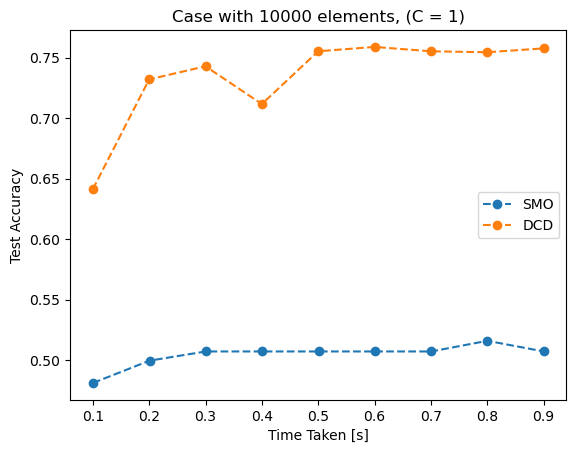

[0.6516666666666666, 0.6195833333333334, 0.7135833333333333, 0.6301666666666667, 0.69275, 0.6924166666666667, 0.7301666666666666, 0.6164166666666666, 0.744, 0.75675, 0.7664166666666666, 0.768, 0.766, 0.7698333333333334, 0.7576666666666667, 0.769, 0.7713333333333333, 0.7619166666666667, 0.7691666666666667, 0.7715]
[0.6446666666666667, 0.615, 0.7143333333333334, 0.6263333333333333, 0.687, 0.6943333333333334, 0.729, 0.61, 0.7406666666666667, 0.756, 0.7603333333333333, 0.7616666666666667, 0.757, 0.761, 0.752, 0.7603333333333333, 0.763, 0.7606666666666667, 0.7586666666666667, 0.7643333333333333]


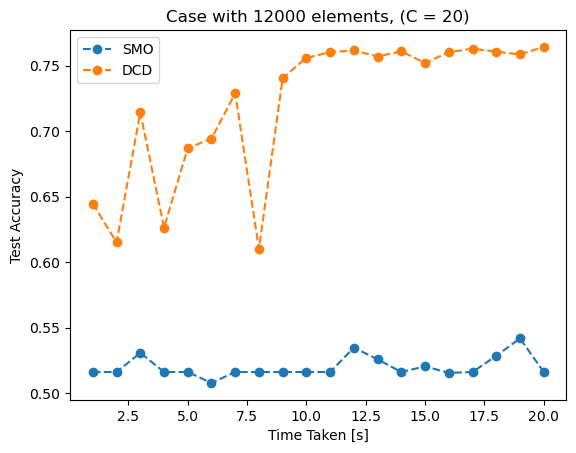

In [78]:
plot_over_time(12500, 1, train = False, save_fig = "time_4.png", suffix = "small_time")
plot_over_time(15000, 20, train = False, save_fig = "time_5.png")

In [ ]:
plot_over_time(12500, 1, train = False, save_fig = "time_1.png")
plot_over_time(15000, 1, train = False, save_fig = "time_2.png")
dcd_plot_over_time(580000, 1, train = False, save_fig = "time_3.png")